In [50]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection, preprocessing


In [51]:
# Load data

feature = pd.read_csv('fish_market_feature.csv')
label = pd.read_csv('fish_market_label.csv')

x = feature.values
y = label.values

print(f"{x.shape = }, {y.shape = }")


x.shape = (124, 5), y.shape = (124, 1)


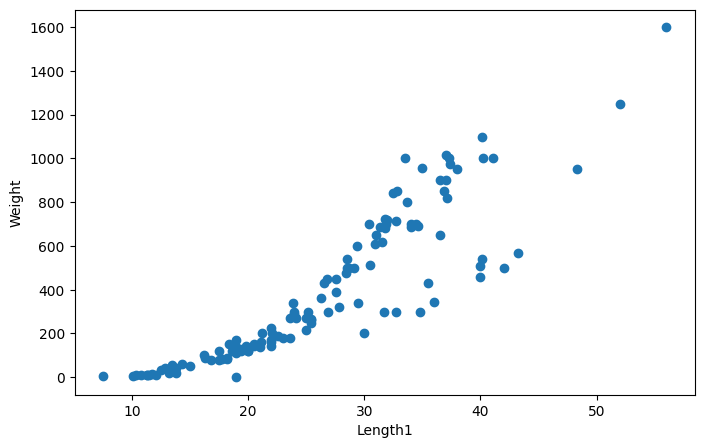

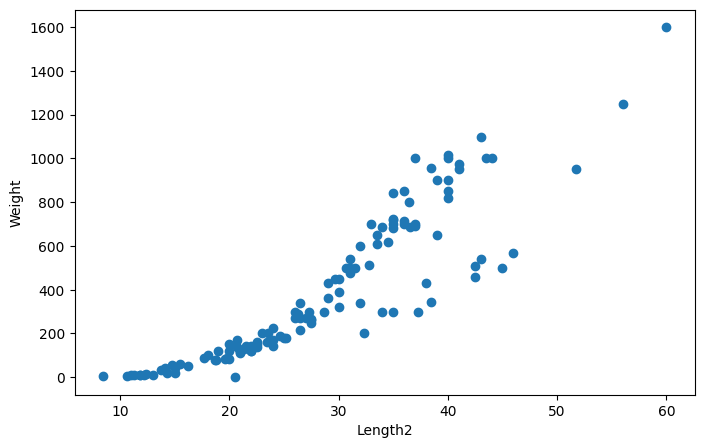

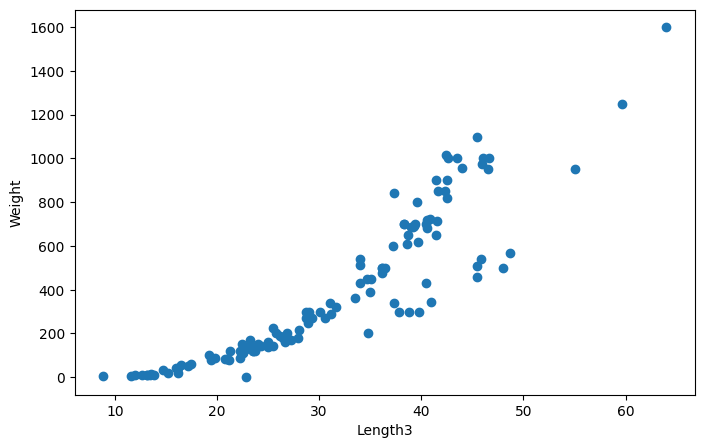

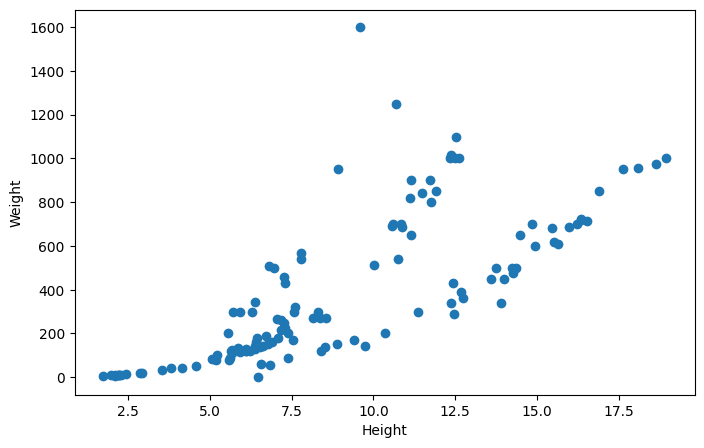

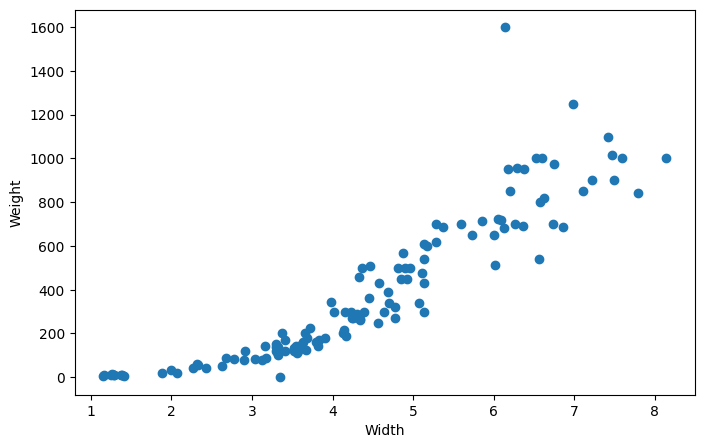

In [52]:
# Plot each feature

for column_name in feature.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(feature[column_name], label['Weight'], 'o')
    plt.xlabel(column_name)
    plt.ylabel('Weight')
    plt.show()


In [53]:
x_train, x_val, y_train, y_val = map(
    preprocessing.scale,
    model_selection.train_test_split(x, y, test_size=0.5, random_state=48),
)

In [54]:
def design_matrix(x, order=1):
    # TODO: Vectorize... *eventually*? Maybe?
    return np.hstack(
        [np.ones((x.shape[0], 1))]  # Bias
        + [x[:, i, None] ** np.arange(1, order+1)[None, :] for i in range(x.shape[1])]  # Polynomials of x_n
    )


In [55]:
# Helper for running a model
def run_model(model, m=1, **kwargs):
    x_d_train = design_matrix(x_train, order=m)
    x_d_val = design_matrix(x_val, order=m)

    reg = model(fit_intercept=False, **kwargs)

    reg.fit(x_d_train, y_train)

    yhat_train = reg.predict(x_d_train)
    mse_train = ((y_train - yhat_train) ** 2).mean()

    yhat_val = reg.predict(x_d_val)
    mse_val = ((y_val - yhat_val) ** 2).mean()

    return mse_train, mse_val


In [56]:
# Find the optimal regression type
def test_model(model, **kwargs):
    mse_train, mse_val = run_model(model, **kwargs)
    print(f"{model.__name__: <18}: {mse_train = : <4.3f}, {mse_val = :<4.3f}")

test_model(linear_model.LinearRegression)
test_model(linear_model.Lasso, alpha=0.02)  # Not good
test_model(linear_model.Ridge, alpha=0.02)


LinearRegression  : mse_train = 0.130, mse_val = 0.099
Lasso             : mse_train = 1.828, mse_val = 1.847
Ridge             : mse_train = 0.130, mse_val = 0.100


Lasso regularization yielded bad loss. Since results from LinearRegression can be simulated with Ridge with `alpha = 0`, we decided to continue with just `Ridge` instead.

/home/newo/.local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.80036e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[]

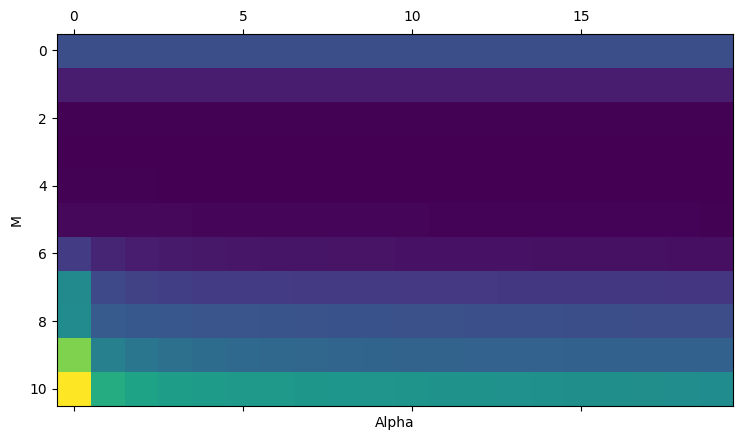

In [57]:
# Plot the performance of different M and alpha values

M_values = np.arange(11)
alpha_values = np.linspace(0, 0.2, 20)

grid = np.empty((M_values.size, alpha_values.size))

for i, M in enumerate(M_values):
    for j, alpha in enumerate(alpha_values):
        grid[i, j] = run_model(linear_model.Ridge, M, alpha=alpha)[1]

plt.matshow(np.log(grid))
plt.xlabel("Alpha")
plt.ylabel("M")
plt.plot()

In [61]:
alphas = np.linspace(0, 0.5, 60)
for a in alphas:
    mse_train, mse_val = run_model(linear_model.Ridge, m = 3, alpha=0.065)
    print(f"Alpha = {a:.2f}: MSE Val = {mse_val:.4f}")


Alpha = 0.00: MSE Val = 0.0323
Alpha = 0.01: MSE Val = 0.0323
Alpha = 0.02: MSE Val = 0.0323
Alpha = 0.03: MSE Val = 0.0323
Alpha = 0.03: MSE Val = 0.0323
Alpha = 0.04: MSE Val = 0.0323
Alpha = 0.05: MSE Val = 0.0323
Alpha = 0.06: MSE Val = 0.0323
Alpha = 0.07: MSE Val = 0.0323
Alpha = 0.08: MSE Val = 0.0323
Alpha = 0.08: MSE Val = 0.0323
Alpha = 0.09: MSE Val = 0.0323
Alpha = 0.10: MSE Val = 0.0323
Alpha = 0.11: MSE Val = 0.0323
Alpha = 0.12: MSE Val = 0.0323
Alpha = 0.13: MSE Val = 0.0323
Alpha = 0.14: MSE Val = 0.0323
Alpha = 0.14: MSE Val = 0.0323
Alpha = 0.15: MSE Val = 0.0323
Alpha = 0.16: MSE Val = 0.0323
Alpha = 0.17: MSE Val = 0.0323
Alpha = 0.18: MSE Val = 0.0323
Alpha = 0.19: MSE Val = 0.0323
Alpha = 0.19: MSE Val = 0.0323
Alpha = 0.20: MSE Val = 0.0323
Alpha = 0.21: MSE Val = 0.0323
Alpha = 0.22: MSE Val = 0.0323
Alpha = 0.23: MSE Val = 0.0323
Alpha = 0.24: MSE Val = 0.0323
Alpha = 0.25: MSE Val = 0.0323
Alpha = 0.25: MSE Val = 0.0323
Alpha = 0.26: MSE Val = 0.0323
Alpha = 

The alpha doesn't seem to have much of an effect for `M` smaller than 6-7.

The optimal M value is around 3-5, so we will continue with `M=3` and `alpha=0.02`

In [59]:
x_test = pd.read_csv('fish_market_test_feature.csv').values
y_test = pd.read_csv('fish_market_test_label.csv').values
x_test = preprocessing.scale(x_test)
y_test = preprocessing.scale(y_test)

In [60]:
# Create the final regression

x_d_train = design_matrix(x_train, order=3)
x_d_val = design_matrix(x_val, order=3)
x_d_test = design_matrix(x_test, order=3)

reg = linear_model.Ridge(fit_intercept=False, alpha=0.06)

reg.fit(x_d_train, y_train)

yhat_train = reg.predict(x_d_train)
mse_train = ((y_train - yhat_train) ** 2).mean()

yhat_val = reg.predict(x_d_val)
mse_val = ((y_val - yhat_val) ** 2).mean()

yhat_test = reg.predict(x_d_test)
mse_test = ((y_test - yhat_test) ** 2).mean()

print("Final regression")
print(f"Training MSE: {mse_train:.5f}")
print(f"Validation MSE: {mse_val:.5f}")
print(f"Test MSE: {mse_test:.5f}")

print(run_model(linear_model.Ridge, 3, alpha=0.02))

Final regression
Training MSE: 0.01150
Validation MSE: 0.03226
Test MSE: 0.02340
(0.011248754220384289, 0.032448018002749476)
